(7, 8, 0, [0, 4, 7])
[[7 8 3 9]
 [7 8 3 2]
 [7 7 8 3]]


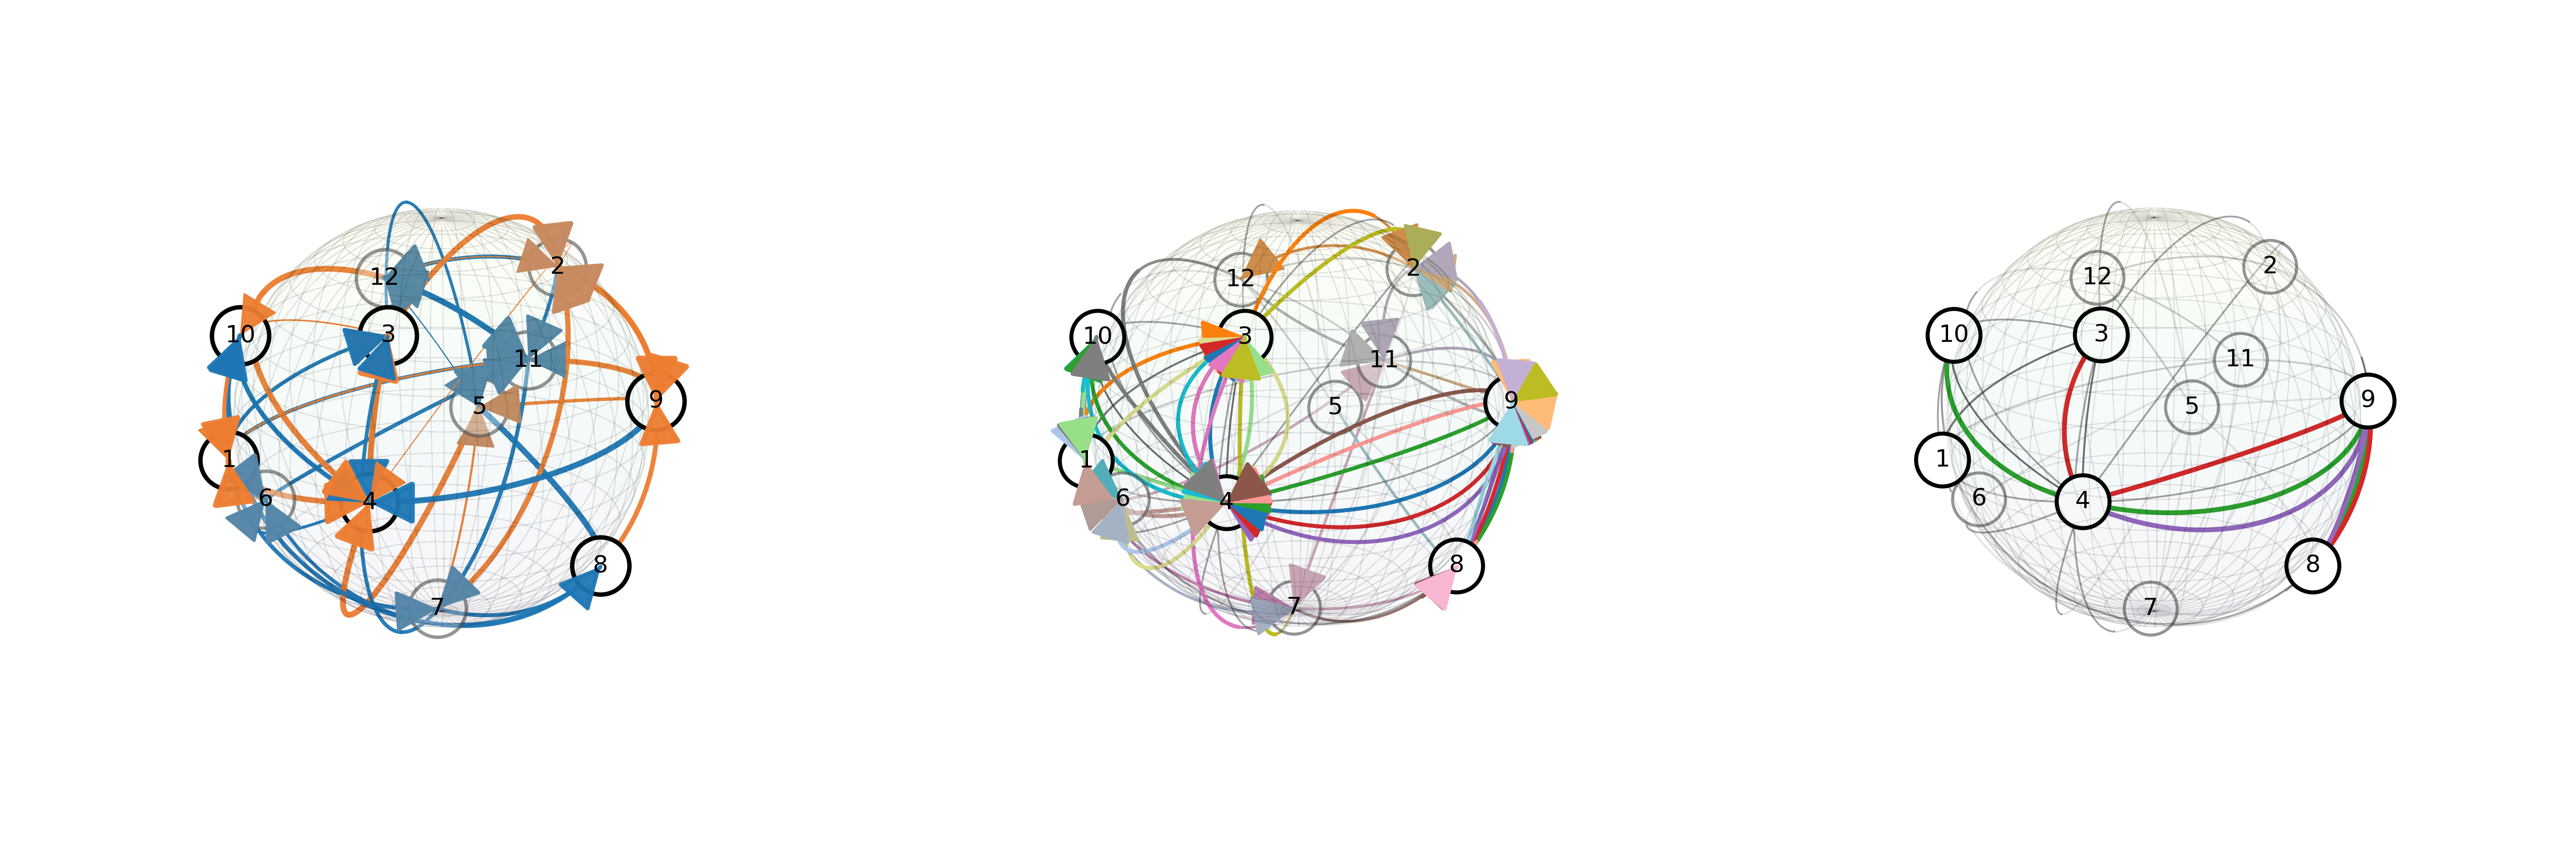

In [1]:
# -*- coding: utf-8 -*-
# Seeds 1..10:
# Left  panel: cognitive map (actions-only) on PCA(3) sphere (from 20 eps)
# Middle panel: all 20 episodes (tab20 colors)
# Right panel: auto-chosen ordered pair (u→v) with distance 1, where at least 3
#              of the 20 episodes start at u, share the same first action, and visit v.
#              Those 3 episodes reuse the exact tab20 colors from the middle panel.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
import matplotlib
# ──────────────────────────────────────────────────────────────────────────────
# Config
# ──────────────────────────────────────────────────────────────────────────────
N, A, K = 12, 2, 2
NUM_EPISODES_EMBED = 20   # exactly 20 episodes for embedding + middle panel
EP_LEN_EMBED = 3          # episode length for the 20 episodes
SEEDS = [54]#,191]#list(range(200, 300))  # 1..10
N_SHOW_EPS_RIGHT = 3

# Colors for actions
ORANGE = (237/255,125/255,49/255)   # action 0
BLUE   = (30/255,119/255,180/255)   # action 1

# Drawing params
EDGE_LW_FRONT = 2.6
EDGE_LW_BACK  = 2.0
ARROW_LENGTH  = 0.10     # fraction of sphere radius
ARROW_MUT     = 30       # arrowhead size

def prob_to_alpha(p, alpha_min=0.18, alpha_max=0.98, gamma=0.7):
    p = float(np.clip(p, 0.0, 1.0))
    return alpha_min + (alpha_max - alpha_min) * (p ** gamma)

# ──────────────────────────────────────────────────────────────────────────────
# Random MDP
# ──────────────────────────────────────────────────────────────────────────────
def build_random_mdp(rng, N=12, A=2, K=2):
    P = np.zeros((A, N, N), float)
    for s in range(N):
        for a in range(A):
            succ  = rng.integers(0, N, size=K)            # allow repeats/self-loops
            probs = rng.dirichlet(np.ones(K))
            for t, p in zip(succ, probs):
                P[a, s, int(t)] += float(p)
        for a in range(A):
            rs = P[a, s].sum()
            P[a, s] = P[a, s] / rs if rs > 0 else 1.0 / N
    return P

def edges_with_actions(P, prob_threshold=1e-12):
    """
    Return [(s, t, a*, p_max)] where a* = argmax_a P[a,s,t], p_max = max_a P[a,s,t].
    """
    A, N, _ = P.shape
    edges = []
    maxprob = P.max(axis=0)
    argact  = P.argmax(axis=0)
    for s in range(N):
        for t in range(N):
            p = float(maxprob[s, t])
            if p > prob_threshold:
                a = int(argact[s, t])
                edges.append((s, t, a, p))
    return edges

# ──────────────────────────────────────────────────────────────────────────────
# Episodes for embedding + middle panel (record first action)
# ──────────────────────────────────────────────────────────────────────────────
def generate_episodes_with_a0(P, num_episodes=20, ep_len=6, rng=None):
    """
    Returns:
      episodes: list of state-index trajectories (length = ep_len+1)
      a0_list:  list of first actions used (int in [0,A-1])
      epi_Q:    (num_episodes, N) unique-visit encoding for embedding
    """
    A, N, _ = P.shape
    if rng is None: rng = np.random.default_rng()
    tables = {(a, s): (np.arange(N, dtype=int), P[a, s].astype(float)) for a in range(A) for s in range(N)}
    def step_next(s, a):
        targets, probs = tables[(a, s)]
        return int(rng.choice(targets, p=probs))
    episodes, a0_list = [], []
    for _ in range(num_episodes):
        s = int(rng.integers(0, N))
        traj = [s]
        a0 = int(rng.integers(0, A))
        s = step_next(s, a0); traj.append(s)
        for _k in range(ep_len-1):
            a = int(rng.integers(0, A))
            s = step_next(s, a); traj.append(s)
        episodes.append(traj)
        a0_list.append(a0)
    epi_Q = np.zeros((num_episodes, N), float)
    for m, traj in enumerate(episodes):
        epi_Q[m, np.unique(traj)] = 1.0
    return episodes, a0_list, epi_Q

# ──────────────────────────────────────────────────────────────────────────────
# 3D helpers (sphere + curves)
# ──────────────────────────────────────────────────────────────────────────────
class Arrow3D(FancyArrowPatch):
    """2D arrow projected from 3D endpoints."""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = (np.asarray(xs, float), np.asarray(ys, float), np.asarray(zs, float))
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        return float(np.min(zs))

def _unit(v):
    v = np.asarray(v, float); n = np.linalg.norm(v)
    return v / (n + 1e-12)

def _slerp(p, q, t):
    p = _unit(p); q = _unit(q)
    dot = np.clip(np.dot(p, q), -1.0, 1.0)
    omg = np.arccos(dot)
    if omg < 1e-9: return _unit((1-t)*p + t*q)
    so = np.sin(omg)
    return (np.sin((1-t)*omg)/so)*p + (np.sin(t*omg)/so)*q

def _spherical_bezier_points(p, c, q, r=1.0, n=160, lift=1.003):
    ts = np.linspace(0, 1, n); out = []
    for t in ts:
        a = _slerp(p, c, t); b = _slerp(c, q, t); x = _slerp(a, b, t)
        out.append(_unit(x))
    return (r*lift) * np.vstack(out)

def _view_vector(ax):
    elev = float(np.deg2rad(np.asarray(ax.elev).item()))
    azim = float(np.deg2rad(np.asarray(ax.azim).item()))
    return np.array([np.cos(elev)*np.cos(azim),
                     np.cos(elev)*np.sin(azim),
                     np.sin(elev)], dtype=float)

def _segment_front_back(pts, vdir, iters=12):
    pts = np.asarray(pts, float).reshape(-1, 3)
    vdir = np.asarray(vdir, float).reshape(3,)
    u = pts / (np.linalg.norm(pts, axis=1, keepdims=True) + 1e-12)
    s = u @ vdir; s[np.abs(s) < 1e-12] = 1e-12
    segs, cur_pts = [], [pts[0]]; cur_front = s[0] >= 0
    for i in range(1, len(pts)):
        same = (s[i] >= 0) == cur_front
        if same:
            cur_pts.append(pts[i])
        else:
            a, b = pts[i-1], pts[i]; t0, t1 = 0.0, 1.0
            for _ in range(iters):
                t = 0.5*(t0 + t1)
                m = a*(1-t) + b*t; m /= (np.linalg.norm(m) + 1e-12)
                if (np.dot(m, vdir) >= 0) == cur_front: t0 = t
                else:                                     t1 = t
            x = a*(1-t1) + b*t1
            cur_pts.append(x); segs.append((np.vstack(cur_pts), cur_front))
            cur_pts = [x, pts[i]]; cur_front = not cur_front
    segs.append((np.vstack(cur_pts), cur_front))
    return segs

def _cover_with_gray(base_color, gray_level=0.6, alpha=0.45):
    """Visual cue for back-of-sphere segments: overlay with translucent gray."""
    r, g, b, a = mcolors.to_rgba(base_color)
    gl = float(gray_level)
    r2 = alpha*gl + (1-alpha)*r
    g2 = alpha*gl + (1-alpha)*g
    b2 = alpha*gl + (1-alpha)*b
    a2 = 1 - (1 - a)*(1 - alpha)
    return (r2, g2, b2, a2)

# ──────────────────────────────────────────────────────────────────────────────
# Embedding & drawing
# ──────────────────────────────────────────────────────────────────────────────
def sphere_positions_from_Q(Q, r=1.0, rng_seed=42):
    X = np.asarray(Q, float).T.copy()              # (states, episodes)
    P3 = PCA(n_components=3, random_state=rng_seed).fit_transform(X)
    P3 = r * P3 / np.maximum(np.linalg.norm(P3, axis=1, keepdims=True), 1e-12)
    return {i: P3[i] for i in range(P3.shape[0])}
# 1) Add a width mapping helper (top-level, near prob_to_alpha or replace it):
def prob_to_lw(p, lw_min=0.2, lw_max=3.0, gamma=0.7):
    """Monotone width map; gamma<1 emphasizes differences at low p."""
    p = float(np.clip(p, 0.0, 1.0))
    return lw_min + (lw_max - lw_min) * (p ** gamma)

def draw_actions_only(ax, pos, edges_with_act, r=1.0):
    ax.view_init(elev=20, azim=45)
    # faint sphere
    u = np.linspace(0, 2*np.pi, 80); v = np.linspace(0, np.pi, 40)
    xs = 0.96*r * np.outer(np.cos(u),  np.sin(v))
    ys = 0.96*r * np.outer(np.sin(u),  np.sin(v))
    zs = 0.96*r * np.outer(np.ones_like(u), np.cos(v))
    norm = plt.Normalize(zs.min(), zs.max())
    facecols = matplotlib.colormaps.get_cmap("viridis")(norm(zs))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                    facecolors=facecols, edgecolor=(0,0,0,0.05),
                    linewidth=0.3, antialiased=False,
                    alpha=0.02, shade=False, zorder=0)

    vdir = _view_vector(ax)
    eps_front = 0.01*r; eps_back = 0.01*r
    MIN_FRONT_SEG_LEN = 0.08 * r   # threshold for placing arrowheads

    def _add_arrow(seg, lw, color, z):
        p_end  = seg[-1]
        p_prev = seg[-2]
        direction = p_end - p_prev
        L = np.linalg.norm(direction) + 1e-12
        direction = direction / L
        # scale arrow length to local segment to avoid overshoot on tiny tails
        L_arrow = min(ARROW_LENGTH, 0.6 * L)
        a0 = p_end - direction * L_arrow
        a1 = p_end
        arr = Arrow3D([a0[0], a1[0]], [a0[1], a1[1]], [a0[2], a1[2]],
                      mutation_scale=45, lw=lw,
                      arrowstyle='-|>', color=color, zorder=z)
        arr.set_clip_on(False)
        ax.add_artist(arr)

    for (s, t, a_star, p_max) in edges_with_act:
        p = _unit(pos[s]); q = _unit(pos[t])
        nrm = _unit(np.cross(p, q))
        mid = _unit(p + q) if np.linalg.norm(p+q) > 1e-9 else _unit(p + 1e-3*nrm)
        c = _unit(mid) * r
        curve = _spherical_bezier_points(p, c, q, r=r, n=200, lift=1.002)

        col = ORANGE if a_star == 0 else BLUE
        col_rgba = (*col, 0.95)
        lw_main = prob_to_lw(p_max)

        last_front_seg = None; last_front_len = 0.0
        last_back_seg  = None; last_back_len  = 0.0

        for seg, is_front in _segment_front_back(curve, vdir):
            if len(seg) < 2:
                continue
            seg2 = seg + (eps_front if is_front else -eps_back) * vdir
            ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                    color=col_rgba,
                    lw=lw_main,
                    zorder=4 if is_front else 1,
                    solid_capstyle="round")
            diffs = np.diff(seg2, axis=0)
            seg_len = float(np.sum(np.linalg.norm(diffs, axis=1)))
            if is_front:
                last_front_seg = seg2
                last_front_len = seg_len
            else:
                last_back_seg  = seg2
                last_back_len  = seg_len

        # Place arrowheads
        endpoint_front = (np.dot(_unit(q), vdir) >= 0.0)
        endpoint_back  = not endpoint_front

        # Front arrow (unchanged behavior)
        if last_front_seg is not None and endpoint_front and last_front_len >= MIN_FRONT_SEG_LEN:
            _add_arrow(last_front_seg, lw_main, col_rgba, 6)

        # Back arrow (dimmed + lower z-order)
        if last_back_seg is not None and endpoint_back and last_back_len >= MIN_FRONT_SEG_LEN:
            back_col = _cover_with_gray(col_rgba, gray_level=0.60, alpha=0.45)
            _add_arrow(last_back_seg, lw_main*0.9, back_col, 2)

    # nodes (white) + labels
    front_nodes, back_nodes = [], []
    for i, pp in pos.items():
        (front_nodes if np.dot(_unit(pp), vdir) >= 0 else back_nodes).append(i)

    for i in back_nodes:
        p = np.asarray(pos[i]) - eps_back*vdir
        ax.scatter(*p, s=820, marker="o",
                   facecolors=(1,1,1,0.35), edgecolors=(0.3,0.3,0.3,0.6),
                   linewidths=1.7, depthshade=False, zorder=2)

    for i in front_nodes:
        p = np.asarray(pos[i])
        ax.scatter(*p, s=820, marker="o",
                   facecolors="white", edgecolors="black",
                   linewidths=2.2, depthshade=False, zorder=5)

    for i, p in pos.items():
        ax.text(float(p[0]), float(p[1]), float(p[2]),
                str(i+1), ha="center", va="center", fontsize=12,
                zorder=100, clip_on=False)

    ax.set_axis_off()
    ax.set_box_aspect([1,1,1])


def _draw_edges_gray(ax, pos, all_edges, r=1.0):
    vdir = _view_vector(ax)
    eps_front = 0.01*r; eps_back = 0.01*r
    edge_color_front = (0.1, 0.1, 0.1, 0.4)
    edge_color_back  = (0.55, 0.55, 0.55, 0.25)
    for (u_, v_) in all_edges:
        p = _unit(pos[u_]); q = _unit(pos[v_])
        nrm = _unit(np.cross(p, q))
        mid = _unit(p + q) if np.linalg.norm(p+q) > 1e-9 else _unit(p + 1e-3*nrm)
        c = _unit(mid) * r
        gc = _spherical_bezier_points(p, c, q, r=r, n=120, lift=1.001)
        for seg, is_front in _segment_front_back(gc, vdir):
            if len(seg) < 2: continue
            seg2 = seg + (eps_front if is_front else -eps_back)*vdir
            ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                    color=edge_color_front if is_front else edge_color_back,
                    lw=0.9, zorder=3 if is_front else 1, solid_capstyle="round")

def _draw_nodes_labels(ax, pos, r=1.0):
    vdir = _view_vector(ax)
    eps_back = 0.01*r
    front_nodes, back_nodes = [], []
    for i, pp in pos.items():
        (front_nodes if np.dot(_unit(pp), vdir) >= 0 else back_nodes).append(i)
    for i in back_nodes:
        p = np.asarray(pos[i]) - eps_back*vdir
        ax.scatter(*p, s=700, marker="o",
                   facecolors=(1,1,1,0.35), edgecolors=(0.3,0.3,0.3,0.6),
                   linewidths=1.5, depthshade=False, zorder=2)
    for i in front_nodes:
        p = np.asarray(pos[i])
        ax.scatter(*p, s=700, marker="o",
                   facecolors="white", edgecolors="black",
                   linewidths=2.0, depthshade=False, zorder=5)
    for i, p in pos.items():
        ax.text(float(p[0]), float(p[1]), float(p[2]),
                str(i+1), ha="center", va="center", fontsize=12,
                zorder=100, clip_on=False)

def draw_all_episodes(ax, pos, all_edges, eps_list, r=1.0):
    ax.view_init(elev=20, azim=45)
    # faint sphere
    u = np.linspace(0, 2*np.pi, 80); v = np.linspace(0, np.pi, 40)
    xs = 0.96*r * np.outer(np.cos(u),  np.sin(v))
    ys = 0.96*r * np.outer(np.sin(u),  np.sin(v))
    zs = 0.96*r * np.outer(np.ones_like(u), np.cos(v))
    norm = plt.Normalize(zs.min(), zs.max())
    facecols = matplotlib.colormaps.get_cmap("viridis")(norm(zs))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                    facecolors=facecols, edgecolor=(0,0,0,0.05),
                    linewidth=0.3, antialiased=False,
                    alpha=0.02, shade=False, zorder=0)

    _draw_edges_gray(ax, pos, all_edges, r=r)
    _draw_nodes_labels(ax, pos, r=r)

    # colors for all 20 episodes (tab20)
    cmap = matplotlib.colormaps.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, max(1, len(eps_list))))

    # Small helpers for arrows (mirrors left panel)
    def _add_arrow(seg, lw, color, z):
        p_end  = seg[-1]
        p_prev = seg[-2]
        direction = p_end - p_prev
        L = np.linalg.norm(direction) + 1e-12
        direction = direction / L
        L_arrow = min(ARROW_LENGTH, 0.6 * L)  # avoid overshoot on short tails
        a0 = p_end - direction * L_arrow
        a1 = p_end
        arr = Arrow3D([a0[0], a1[0]], [a0[1], a1[1]], [a0[2], a1[2]],
                      mutation_scale=ARROW_MUT*1.5, lw=lw,
                      arrowstyle='-|>', color=color, zorder=z)
        arr.set_clip_on(False)
        ax.add_artist(arr)

    MIN_SEG_LEN = 0.08 * r  # threshold for placing arrowheads

    # offset logic
    edge_use_counter = {}
    for (u_, v_) in {(min(u,v), max(u,v)) for ep in eps_list for u,v in zip(ep[:-1], ep[1:])}:
        edge_use_counter[(u_, v_)] = 0

    base_offset_amp = 0.18
    for idx, ep in enumerate(eps_list, start=1):
        color = colors[(idx-1) % len(colors)]
        back_color = _cover_with_gray(color, gray_level=0.60, alpha=0.45)

        for u_, v_ in zip(ep[:-1], ep[1:]):
            e = (min(u_, v_), max(u_, v_))
            k = edge_use_counter.get(e, 0)
            sign = -1 if (k % 2) else +1
            amp  = base_offset_amp * (1 + k // 2)

            p = _unit(pos[u_]); q = _unit(pos[v_])
            nrm = _unit(np.cross(p, q))
            mid = _unit(p + q) if np.linalg.norm(p+q) > 1e-9 else _unit(p + 1e-3*nrm)
            c = _unit(mid + sign * amp * nrm) * r

            curve = _spherical_bezier_points(p, c, q, r=r, n=192, lift=1.004)
            vdir = _view_vector(ax)
            eps_front = 0.01*r; eps_back = 0.01*r

            last_front_seg = None; last_front_len = 0.0
            last_back_seg  = None; last_back_len  = 0.0

            # draw curve split by front/back
            for seg, is_front in _segment_front_back(curve, vdir):
                if len(seg) < 2: 
                    continue
                seg2 = seg + (eps_front if is_front else -eps_back)*vdir
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=color if is_front else back_color,
                        lw=2.0 if is_front else 1.4,
                        zorder=6 if is_front else 2,
                        solid_capstyle="round")

                # track last front/back piece for arrow placement
                diffs = np.diff(seg2, axis=0)
                seg_len = float(np.sum(np.linalg.norm(diffs, axis=1)))
                if is_front:
                    last_front_seg = seg2
                    last_front_len = seg_len
                else:
                    last_back_seg  = seg2
                    last_back_len  = seg_len

            # endpoint visibility: decide whether to show front/back arrow
            endpoint_front = (np.dot(_unit(q), vdir) >= 0.0)
            endpoint_back  = not endpoint_front

            # front arrow
            if last_front_seg is not None and endpoint_front and last_front_len >= MIN_SEG_LEN:
                _add_arrow(last_front_seg, lw=2.0, color=color, z=8)

            # back arrow (dimmed)
            if last_back_seg is not None and endpoint_back and last_back_len >= MIN_SEG_LEN:
                dim_col = _cover_with_gray(color, gray_level=0.60, alpha=0.45)
                _add_arrow(last_back_seg, lw=1.6, color=dim_col, z=3)

            edge_use_counter[e] = k + 1

    ax.set_axis_off()
    ax.set_box_aspect([1,1,1])


def draw_selected_episodes(ax, pos, all_edges, eps_indices, eps_list, colors_tab20, u, v, a0maj, r=1.0):
    """Draw ONLY the selected episodes, with colors taken from the 20-episode palette."""
    ax.view_init(elev=20, azim=45)
    # faint sphere
    u_s = np.linspace(0, 2*np.pi, 80); v_s = np.linspace(0, np.pi, 40)
    xs = 0.96*r * np.outer(np.cos(u_s),  np.sin(v_s))
    ys = 0.96*r * np.outer(np.sin(u_s),  np.sin(v_s))
    zs = 0.96*r * np.outer(np.ones_like(u_s), np.cos(v_s))
    norm = plt.Normalize(zs.min(), zs.max())
    facecols = matplotlib.colormaps.get_cmap("viridis")(norm(zs))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                    facecolors=facecols, edgecolor=(0,0,0,0.05),
                    linewidth=0.3, antialiased=False,
                    alpha=0.02, shade=False, zorder=0)

    _draw_edges_gray(ax, pos, all_edges, r=r)
    _draw_nodes_labels(ax, pos, r=r)

    # offset logic
    edge_use_counter = {}
    selected_eps = [eps_list[i] for i in eps_indices]
    for (u_, v_) in {(min(u0,v0), max(u0,v0)) for ep in selected_eps for u0,v0 in zip(ep[:-1], ep[1:])}:
        edge_use_counter[(u_, v_)] = 0

    base_offset_amp = 0.20
    for ei in eps_indices:
        ep = eps_list[ei]
        color = colors_tab20[ei % len(colors_tab20)]
        back_color = _cover_with_gray(color, gray_level=0.60, alpha=0.45)
        for u_, v_ in zip(ep[:-1], ep[1:]):
            e = (min(u_, v_), max(u_, v_))
            k = edge_use_counter.get(e, 0)
            sign = -1 if (k % 2) else +1
            amp  = base_offset_amp * (1 + k // 2)

            p = _unit(pos[u_]); q = _unit(pos[v_])
            nrm = _unit(np.cross(p, q))
            mid = _unit(p + q) if np.linalg.norm(p+q) > 1e-9 else _unit(p + 1e-3*nrm)
            c = _unit(mid + sign * amp * nrm) * r

            curve = _spherical_bezier_points(p, c, q, r=r, n=192, lift=1.004)
            vdir = _view_vector(ax)
            eps_front = 0.01*r; eps_back = 0.01*r
            for seg, is_front in _segment_front_back(curve, vdir):
                if len(seg) < 2: continue
                seg2 = seg + (eps_front if is_front else -eps_back)*vdir
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=color if is_front else back_color,
                        lw=2.4 if is_front else 1.8,
                        zorder=6 if is_front else 2,
                        solid_capstyle="round")
            edge_use_counter[e] = k + 1

    a_str = "a=0 (orange)" if a0maj == 0 else "a=1 (blue)"
#     ax.set_title(f"3 eps: start {u+1} → … → {v+1} (same colors), first action {a_str}")
    ax.set_axis_off()
    ax.set_box_aspect([1,1,1])

# ──────────────────────────────────────────────────────────────────────────────
# NEW: auto-pick ordered pair (u→v) and indices
# ──────────────────────────────────────────────────────────────────────────────
def find_pair_and_indices(P, episodes, a0_list, want=3):
    """
    Find ordered (u→v) with distance 1 (∃ a: P[a,u,v] > 0) and ≥want episodes that:
      - start at u,
      - share the same first action (majority among those),
      - include v somewhere in traj[1:].
    Returns (u, v, a0_major, indices[:want]) or None if not found.
    """
    A, N, _ = P.shape
    candidates = []
    for u in range(N):
        for v in range(N):
            if u == v: 
                continue
            if float(P[:, u, v].sum()) <= 1e-12:
                continue  # not distance 1
            idxs = [i for i, ep in enumerate(episodes) if (len(ep) > 1 and ep[0] == u and (v in ep[1:]))]
            if len(idxs) < want:
                continue
            a0s = [a0_list[i] for i in idxs]
            vals, counts = np.unique(a0s, return_counts=True)
            a0maj = int(vals[np.argmax(counts)])
            group = [i for i in idxs if a0_list[i] == a0maj]
            if len(group) >= want:
                score = len(group)
                edge_strength = float(P[:, u, v].max())  # prefer stronger direct edge if tie
                candidates.append((score, edge_strength, u, v, a0maj, group))
    if not candidates:
        return None
    # best: largest group, then strongest edge
    candidates.sort(key=lambda x: (-x[0], -x[1]))
    _, _, u, v, a0maj, group = candidates[0]
    return (u, v, a0maj, group[:want])

# ──────────────────────────────────────────────────────────────────────────────
# Driver
# ──────────────────────────────────────────────────────────────────────────────
def run_all():
    for seed in SEEDS:
        rng = np.random.default_rng(seed)

        # Build MDP and edges
        P = build_random_mdp(rng, N=N, A=A, K=K)
        edges_act = edges_with_actions(P, prob_threshold=1e-12)
        all_edges = [(s, t) for (s, t, _, _) in edges_act]

        # Episodes for embedding + middle panel (exactly 20, record a0)
        eps20, a0_list, epi_Q = generate_episodes_with_a0(P, num_episodes=NUM_EPISODES_EMBED,
                                                          ep_len=EP_LEN_EMBED, rng=rng)
        
        # Sphere positions from those 20 episodes (shared across panels)
        pos = sphere_positions_from_Q(epi_Q, r=1.0, rng_seed=42)

        # Tab20 colors for the 20 episodes (index-aligned)
        cmap = matplotlib.colormaps.get_cmap("tab20")
        colors_tab20 = cmap(np.linspace(0, 1, len(eps20)))

        # Auto-pick an ordered pair (u→v) + 3 matching episode indices
        picked = find_pair_and_indices(P, eps20, a0_list, want=N_SHOW_EPS_RIGHT)
        eps20 = np.array(eps20)
        print(picked)
        eps20[picked[3][1]]=[7,8,3,9]
#         s1=eps20[4]
        s2=eps20[6]
        s3=eps20[8]
#         eps20[4]=eps20[picked[3][0]]
        eps20[6]=eps20[picked[3][0]]
        eps20[8]=eps20[picked[3][2]]
        eps20[picked[3][0]] = s2
#         eps20[picked[3][1]] = s2
        eps20[picked[3][2]] = s3
        picked=(picked[0],picked[1],picked[2],[4,6,8])
        print(np.array(eps20)[picked[3]])
        # Figure with 3 panels
        fig = plt.figure(figsize=(18, 10), dpi=300)
        ax_left   = fig.add_subplot(1, 3, 1, projection="3d")
        ax_middle = fig.add_subplot(1, 3, 2, projection="3d")
        ax_right  = fig.add_subplot(1, 3, 3, projection="3d")

        draw_actions_only(ax_left, pos, edges_act, r=1.0)
        draw_all_episodes(ax_middle, pos, all_edges, eps20, r=1.0)

        if picked is None:
#             ax_right.set_title("No ordered (u→v) with ≥3 qualifying episodes found")
            ax_right.set_axis_off()
            ax_right.set_box_aspect([1,1,1])
        else:
            u, v, a0maj, idxs = picked
            draw_selected_episodes(ax_right, pos, all_edges, idxs, eps20, colors_tab20, u, v, a0maj, r=1.0)

#         fig.suptitle(f"Seed {seed}: map (left), all 20 episodes (middle), selected 3 (right)", y=0.98)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_all()


In [ ]:
# -*- coding: utf-8 -*-
# Benchmark VI (knowing P), online SR, and ECML/U under MAC budgets.
# Saves ALL intermediate results to ./results_* while computing.
# Single run; during evaluation, each (start, goal) pair is rolled out 100 times and averaged per pair.
#
# Plots:
#   1) Success rate vs MACs (log x)
#   2) Mean steps-to-goal vs MACs (log x)

import os, csv, json, math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ──────────────────────────────────────────────────────────────────────────────
# Results I/O helpers
# ──────────────────────────────────────────────────────────────────────────────
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def csv_writer(path, header):
    """Open a csv writer in append mode, creating file & header if missing."""
    file_exists = os.path.exists(path)
    f = open(path, "a", newline="")
    w = csv.writer(f)
    if not file_exists:
        w.writerow(header)
        f.flush()
    return f, w

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

# ──────────────────────────────────────────────────────────────────────────────
# Counters
# ──────────────────────────────────────────────────────────────────────────────
class Counters:
    def __init__(self, name):
        self.name = name
        self.macs = 0
        self.backups = 0
        self.samples = 0
        self.checkpoints = []  # (macs, success_rate, mean_steps)

    def log(self, success_rate, mean_steps):
        self.checkpoints.append((self.macs, success_rate, mean_steps))

def est_sparse_k(P):
    return float((P > 0).sum(axis=2).mean())

# ──────────────────────────────────────────────────────────────────────────────
# MDP + evaluation
# ──────────────────────────────────────────────────────────────────────────────
def build_mdp_dense(N_S, N_A, det_prob=0.0, seed=0):
    if N_S < 2:
        raise ValueError("Need N_S >= 2")
    rng = np.random.default_rng(seed)
    P = np.zeros((N_A, N_S, N_S), dtype=float)
    for s in range(N_S):
        pool = np.delete(np.arange(N_S), s)
        for a in range(N_A):
            if rng.random() < det_prob or N_S == 2:
                d = int(rng.choice(pool))
                P[a, s, d] = 1.0
            else:
                if N_S >= 3:
                    d1, d2 = rng.choice(pool, size=2, replace=False)
                    w = rng.random(2); w /= w.sum()
                    P[a, s, [d1, d2]] = w
                else:
                    d = int(pool[0]); P[a, s, d] = 1.0
    row_sums = P.sum(axis=2, keepdims=True)
    P = np.divide(P, np.where(row_sums == 0, 1, row_sums), where=row_sums!=0)
    return P

def rollout_policy(P, Pi, start, goal, rng, max_steps=1000):
    N_A, N_S, _ = P.shape
    s = int(start); g = int(goal)
    if s == g: return 0
    for t in range(1, max_steps+1):
        a = int(Pi[s, g])
        s = rng.choice(N_S, p=P[a, s])
        if s == g: return t
    return None

def evaluate_goal_conditioned(P, Pi, horizon=1000, rng_seed=0, repeats_per_pair=100):
    """
    For each (s,g), do `repeats_per_pair` rollouts and compute:
      - pair_success_prob = successes / repeats
      - pair_mean_steps = mean steps over successful rollouts (NaN if 0 successes)
    Return:
      - avg_success_rate = mean of pair_success_prob over all s!=g
      - avg_mean_steps   = mean of pair_mean_steps over pairs with at least 1 success
    """
    N_A, N_S, _ = P.shape
    rng = np.random.default_rng(rng_seed)

    pair_succ_probs = []
    pair_steps_means = []

    for s in range(N_S):
        for g in range(N_S):
            if s == g: 
                continue
            succ = 0
            steps_succ = []
            # independent repeats with fresh randomness
            for r in range(repeats_per_pair):
                steps = rollout_policy(P, Pi, s, g, rng, max_steps=horizon)
                if steps is not None:
                    succ += 1
                    steps_succ.append(steps)
            pair_succ_probs.append(succ / repeats_per_pair)
            if len(steps_succ) > 0:
                pair_steps_means.append(float(np.mean(steps_succ)))

    avg_success_rate = float(np.mean(pair_succ_probs)) if pair_succ_probs else np.nan
    avg_mean_steps   = float(np.mean(pair_steps_means)) if pair_steps_means else np.nan
    return avg_success_rate, avg_mean_steps

# ──────────────────────────────────────────────────────────────────────────────
# Value Iteration (absorbing goal) with MAC counting
# ──────────────────────────────────────────────────────────────────────────────
def value_iteration_absorbing_partial(P, goal, max_iter, CTR, k_avg, tol=None, rng_tie=None):
    N_A, N_S, _ = P.shape
    P2 = P.copy()
    P2[:, goal, :] = 0.0
    P2[:, goal, goal] = 1.0
    row_sums = P2.sum(axis=2, keepdims=True)
    np.divide(P2, row_sums, out=P2, where=row_sums>0)

    V = np.zeros(N_S, dtype=float)
    for _ in range(max_iter):
        V_old = V.copy()
        CTR.macs += int(N_S * N_A * k_avg)
        CTR.backups += N_S
        for s in range(N_S):
            if s == goal:
                V[s] = 0.0
            else:
                vals = [1.0 + float(P2[a, s].dot(V_old)) for a in range(N_A)]
                V[s] = min(vals)
        if tol is not None and np.max(np.abs(V - V_old)) < tol:
            break

    if rng_tie is None:
        rng_tie = np.random.default_rng(0)
    Pi_g = np.zeros(N_S, dtype=int)
    for s in range(N_S):
        if s == goal:
            Pi_g[s] = 0
        else:
            q = np.array([1.0 + float(P2[a, s].dot(V)) for a in range(N_A)])
            best = np.min(q)
            cands = np.flatnonzero(np.isclose(q, best))
            Pi_g[s] = int(rng_tie.choice(cands))
    return Pi_g

def VI_curve(P, it_checkpoints, horizon, progress_desc, per_goal_desc, eval_repeats=100):
    N_A, N_S, _ = P.shape
    CTR = Counters("VI")
    k_avg = est_sparse_k(P)
    out = []
    for iters in tqdm(it_checkpoints, desc=progress_desc):
        Pi_all = np.zeros((N_S, N_S), dtype=int)
        for g in tqdm(range(N_S), desc=per_goal_desc, leave=False):
            Pi_all[:, g] = value_iteration_absorbing_partial(P, g, iters, CTR, k_avg, tol=None)
        sr, ms = evaluate_goal_conditioned(P, Pi_all, horizon=horizon, rng_seed=1234, repeats_per_pair=eval_repeats)
        CTR.log(sr, ms)
        out.append((CTR.macs, sr, ms))
    return CTR, np.array(out)

# ──────────────────────────────────────────────────────────────────────────────
# ECML / U-table with MAC counting
# ──────────────────────────────────────────────────────────────────────────────
def generate_episode(P, length, rng):
    N_A, N_S, _ = P.shape
    s = int(rng.integers(P.shape[1]))
    traj = [s]; acts = []
    for _ in range(length):
        a = int(rng.integers(N_A))
        s = int(rng.choice(P.shape[1], p=P[a, s]))
        traj.append(s); acts.append(a)
    return traj, acts

def ecml_stream(P, N_A, episode_len, episodes_total, checkpoints, horizon, seed,
                progress_desc, eval_repeats=100):
    N_S = P.shape[1]
    U = np.zeros((N_S * N_A, N_S), dtype=np.int32)
    CTR = Counters("ECML")
    rng = np.random.default_rng(seed)

    def ecml_policy_table(U):
        Pi = np.zeros((N_S, N_S), dtype=int)
        for s in range(N_S):
            for g in range(N_S):
                if s == g:
                    Pi[s, g] = 0
                else:
                    row = U[s*N_A:(s+1)*N_A, g]
                    mx = row.max()
                    cands = np.flatnonzero(row == mx)
                    Pi[s, g] = int(rng.choice(cands))
        return Pi

    ck_set = set(checkpoints)
    for epi in tqdm(range(1, episodes_total+1), desc=progress_desc):
        traj, acts = generate_episode(P, episode_len, rng)
        Q = np.zeros(N_S, dtype=np.int16)
        Q[np.asarray(traj, dtype=int)] = 1
        idx = int(traj[0]) * N_A + int(acts[0])
        U[idx] += Q

        CTR.backups += 1
        CTR.samples += episode_len
        CTR.macs += int(Q.sum())   # or use: episode_len + 1

        if epi in ck_set:
            Pi = ecml_policy_table(U)
            sr, ms = evaluate_goal_conditioned(P, Pi, horizon=horizon, rng_seed=2024, repeats_per_pair=eval_repeats)
            CTR.log(sr, ms)

    return CTR, np.array(CTR.checkpoints)

# ──────────────────────────────────────────────────────────────────────────────
# Online SR (TD(0)) with MAC counting
# ──────────────────────────────────────────────────────────────────────────────
def train_sr_stream(P, episode_len, episodes_total, checkpoints, alpha, gamma_sr,
                    horizon, seed, progress_desc, eval_repeats=100):
    N_A, N_S, _ = P.shape
    rng = np.random.default_rng(seed)
    M = np.zeros((N_S, N_S), dtype=float)
    counts = np.zeros((N_A, N_S, N_S), dtype=float)
    CTR = Counters("SR")
    eye = np.eye(N_S, dtype=float)

    def P_from_counts(counts):
        P_est = np.zeros_like(counts)
        for a in range(N_A):
            row_sum = counts[a].sum(axis=1, keepdims=True)
            np.divide(counts[a], np.where(row_sum == 0, 1, row_sum),
                      out=P_est[a], where=row_sum != 0)
            empties = np.where(row_sum.flatten() == 0)[0]
            if len(empties) > 0:
                P_est[a, empties] = 1.0 / N_S
        return P_est

    def sr_policy_table(P_est, M):
        Pi = np.zeros((N_S, N_S), dtype=int)
        ones = np.ones(N_S, dtype=float)
        for g in range(N_S):
            r_g = ones.copy(); r_g[g] = 0.0
            v_g = M @ r_g
            Qa = 1.0 + gamma_sr * np.tensordot(P_est, v_g, axes=(2, 0))  # (N_A, N_S)
            Pi[:, g] = np.argmin(Qa.T, axis=1)
            Pi[g, g] = 0
        return Pi

    ck_set = set(checkpoints)
    for epi in tqdm(range(1, episodes_total+1), desc=progress_desc):
        s = int(rng.integers(N_S))
        for _ in range(episode_len):
            a = int(rng.integers(N_A))
            s2 = int(rng.choice(N_S, p=P[a, s]))

            counts[a, s, s2] += 1.0

            target = eye[s] + gamma_sr * M[s2]
            M[s] += alpha * (target - M[s])

            CTR.samples += 1
            CTR.backups += 1
            CTR.macs += 2 * N_S

            s = s2

        if epi in ck_set:
            P_est = P_from_counts(counts)
            Pi = sr_policy_table(P_est, M)
            sr, ms = evaluate_goal_conditioned(P, Pi, horizon=horizon, rng_seed=777, repeats_per_pair=eval_repeats)
            CTR.log(sr, ms)

    return CTR, np.array(CTR.checkpoints)

# ──────────────────────────────────────────────────────────────────────────────
# Main experiment (single run), saving all intermediate results as we go
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Settings
    N_S = 32
    N_A = 2
    EPISODE_LEN = 12
    EPISODES_TOTAL = 10_000_00
    HORIZON = 1000

    VI_ITERS   = [1,2,5,10,20,50,100,200,500,1000]
    STREAM_CK  = [100,200,500,1000,2000,5000,10000,20000,50000,100000,200000,1_000_000]

    # Output structure
    base_dir = "./results_32_single"
    ensure_dir(base_dir)
    meta = {
        "N_S": N_S, "N_A": N_A, "EPISODE_LEN": EPISODE_LEN,
        "EPISODES_TOTAL": EPISODES_TOTAL, "HORIZON": HORIZON,
        "VI_ITERS": VI_ITERS, "STREAM_CK": STREAM_CK,
        "EVAL_REPEATS_PER_PAIR": 100
    }
    save_json(meta, os.path.join(base_dir, "meta.json"))

    # Build one fixed MDP
    P = build_mdp_dense(N_S=N_S, N_A=N_A, det_prob=0.0, seed=123)
    print("Avg successors per (s,a): k ≈", est_sparse_k(P))

    # Pre-create per-algo directories
    algo_dirs = {
        "VI":   os.path.join(base_dir, "vi"),
        "SR":   os.path.join(base_dir, "sr"),
        "ECML": os.path.join(base_dir, "ecml"),
    }
    for d in algo_dirs.values():
        ensure_dir(d)

    # Per-algo CSV loggers (append as we compute)
    vi_csv_path   = os.path.join(algo_dirs["VI"],   "rep_001.csv")
    sr_csv_path   = os.path.join(algo_dirs["SR"],   "rep_001.csv")
    ecml_csv_path = os.path.join(algo_dirs["ECML"], "rep_001.csv")

    vi_f, vi_w       = csv_writer(vi_csv_path,   ["macs","success_rate","mean_steps"])
    sr_f, sr_w       = csv_writer(sr_csv_path,   ["macs","success_rate","mean_steps"])
    ecml_f, ecml_w   = csv_writer(ecml_csv_path, ["macs","success_rate","mean_steps"])

    # 1) VI (knows P)
    CTR_vi, curve_vi = VI_curve(
        P, it_checkpoints=VI_ITERS, horizon=HORIZON,
        progress_desc="VI checkpoints (single run)",
        per_goal_desc="VI: goals",
        eval_repeats=100
    )
    for row in curve_vi.tolist():
        vi_w.writerow(row)
    vi_f.flush(); vi_f.close()

    # 2) ECML stream
    CTR_ecml, curve_ecml = ecml_stream(
        P, N_A, EPISODE_LEN, EPISODES_TOTAL, STREAM_CK,
        horizon=HORIZON, seed=42, progress_desc="ECML episodes (single run)",
        eval_repeats=100
    )
    for row in curve_ecml.tolist():
        ecml_w.writerow(row)
    ecml_f.flush(); ecml_f.close()

    # 3) SR stream
    CTR_sr, curve_sr = train_sr_stream(
        P, EPISODE_LEN, EPISODES_TOTAL, STREAM_CK,
        alpha=0.1, gamma_sr=0.95, horizon=HORIZON, seed=24,
        progress_desc="SR episodes (single run)", eval_repeats=100
    )
    for row in curve_sr.tolist():
        sr_w.writerow(row)
    sr_f.flush(); sr_f.close()

    # Dump per-run summaries
    save_json({
        "CTR_vi":   {"macs": CTR_vi.macs,   "backups": CTR_vi.backups,   "samples": CTR_vi.samples},
        "CTR_ecml": {"macs": CTR_ecml.macs, "backups": CTR_ecml.backups, "samples": CTR_ecml.samples},
        "CTR_sr":   {"macs": CTR_sr.macs,   "backups": CTR_sr.backups,   "samples": CTR_sr.samples},
    }, os.path.join(base_dir, f"single_run_summary.json"))

    # ──────────────────────────────────────────────────────────────────────
    # Plot: Success Rate vs MACs (single run), log x
    # ──────────────────────────────────────────────────────────────────────
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(curve_vi[:,0],   curve_vi[:,1],   lw=2, label="VI (knows P)")
    ax1.plot(curve_sr[:,0],   curve_sr[:,1],   lw=2, label="SR (online)")
    ax1.plot(curve_ecml[:,0], curve_ecml[:,1], lw=2, label="ECML / U")
    ax1.set_xscale("log")
    ax1.set_xlabel("MACs (training compute, log scale)")
    ax1.set_ylabel(f"Success rate @ horizon {HORIZON}")
    ax1.set_title("Goal-conditioned success rate vs MACs (per-pair averaged, 100 rollouts)")
    ax1.grid(True, alpha=0.4)
    ax1.legend()
    fig1.tight_layout()
    fig1_path = os.path.join(base_dir, "success_vs_macs.png")
    fig1.savefig(fig1_path, dpi=180)

    # ──────────────────────────────────────────────────────────────────────
    # Plot: Mean Steps vs MACs (single run), log x
    # ──────────────────────────────────────────────────────────────────────
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    ax2.plot(curve_vi[:,0],   curve_vi[:,2],   lw=2, label="VI (knows P)")
    ax2.plot(curve_sr[:,0],   curve_sr[:,2],   lw=2, label="SR (online)")
    ax2.plot(curve_ecml[:,0], curve_ecml[:,2], lw=2, label="ECML / U")
    ax2.set_xscale("log")
    ax2.set_xlabel("MACs (training compute, log scale)")
    ax2.set_ylabel("Mean steps-to-goal (successes only; per-pair averaged)")
    ax2.set_title("Goal-conditioned mean steps vs MACs (per-pair averaged, 100 rollouts)")
    ax2.grid(True, alpha=0.4)
    ax2.legend()
    fig2.tight_layout()
    fig2_path = os.path.join(base_dir, "steps_vs_macs.png")
    fig2.savefig(fig2_path, dpi=180)

    print(f"\nSaved CSVs and plots in: {os.path.abspath(base_dir)}")


Avg successors per (s,a): k ≈ 2.0


VI checkpoints (single run):   0%|          | 0/10 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

VI: goals:   0%|          | 0/32 [00:00<?, ?it/s]

ECML episodes (single run):   0%|          | 0/1000000 [00:00<?, ?it/s]

SR episodes (single run):   0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
# Load aggregate CSVs from ./results and re-plot success/steps vs MACs.
# If the files aren't visible in this environment, the code will explain what is missing.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_dir = "./results"
vi_path   = os.path.join(base_dir, "vi_aggregate.csv")
sr_path   = os.path.join(base_dir, "sr_aggregate.csv")
ecml_path = os.path.join(base_dir, "ecml_aggregate.csv")

missing = [p for p in [vi_path, sr_path, ecml_path] if not os.path.exists(p)]
if missing:
    print("I couldn't find the following files from your local path:\n  - " + "\n  - ".join(missing))
    print("\nIf you upload those three CSVs here or adjust 'base_dir', I'll render the plots immediately.")
else:
    vi   = pd.read_csv(vi_path)
    sr   = pd.read_csv(sr_path)
    ecml = pd.read_csv(ecml_path)

In [ ]:
fig2, ax2 = plt.subplots(figsize=(3,2.5),dpi=300)

series = [
    (vi,   "VI", "o"),   # circle
    (sr,   "SR",  "s"),   # square
    (ecml, "EN",     "^"),   # triangle
]
STREAM_CK  = [100,200,500,1000,2000,5000,10000,20000,50000,100000,200000,1_000_000,2_000_000,5_000_000,10_000_000]

for df, label, mk in series:
    x   = df["macs_mean"].to_numpy()
    y   = df["steps_mean"].to_numpy()
    # ysd = df["steps_std"].to_numpy()  # keep if you later want error bars
    if label=='VI':
        ax2.plot(
        x, y, lw=2, label=label,
        marker=mk, markersize=6, markeredgewidth=1.2,c='tab:pink'
    )
    elif label=='SR':
        ax2.plot(
        x, y, lw=2, label=label,
        marker=mk, markersize=6, markeredgewidth=1.2,c='tab:olive'
    )
        
    else:
        
        ax2.plot(
        x/13*14, y, lw=2, label=label,
        marker=mk, markersize=6, markeredgewidth=1.2,c='tab:green'
    )

    tab:pink,tab:olive,tab:green
    # If you prefer error bars instead of bands, uncomment:
    # ax2.errorbar(x, y, yerr=ysd, fmt=mk, ms=6, mfc='none', mew=1.2, lw=1, capsize=3)
ax2.set_xlim(4*10**3,10**9)
ax2.set_xscale("log")
ax2.set_xticks([10**4,10**6,10**8])
ax2.set_xlabel("MACs")
ax2.set_ylim(0,100)
ax2.set_ylabel("Expected steps")
# ax2.set_title("Goal-conditioned mean steps vs MACs (lower is better)")
ax2.grid(True, alpha=0.4)
ax2.legend(loc='upper right')
fig2.tight_layout()
